In [1]:
import cv2
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from sklearn.cluster import KMeans


In [2]:
df = pd.read_csv('raw_data.csv', sep=";")

In [3]:
df.columns = ["photo_id", "user_internal_id", "user_name", "lat", "longt", "date_taken", "date_upload",  "visit"]

In [4]:
# Converter a coluna date_taken para o tipo datetime
df['date_taken'] = pd.to_datetime(df['date_taken'])

# Agrupar os dados por user_name e calcular a diferença em dias entre a primeira e a última foto
df['first_date_taken'] = df.groupby('user_name')['date_taken'].transform('min')
df['last_date_taken'] = df.groupby('user_name')['date_taken'].transform('max')
df['days_diff'] = (df['last_date_taken'] - df['first_date_taken']).dt.days

# Marcar os usuários como "Turistas" ou "Local" com base na diferença em dias
df['tipo_usuario'] = 'Indefinido'
df.loc[df['days_diff'] <= 40, 'tipo_usuario'] = 'Turista'
df.loc[df['days_diff'] > 40, 'tipo_usuario'] = 'Local'

# Descartar colunas auxiliares adicionadas
df.drop(['first_date_taken', 'last_date_taken', 'days_diff'], axis=1, inplace=True)

# # Escrever os dados manipulados de volta para o arquivo CSV
# df.to_csv('seu_arquivo_manipulado.csv', index=False)


In [5]:
mapa = folium.Map(location=[-7.144126, -34.857480], zoom_start=12)

# Iterar sobre as linhas do DataFrame
for index, row in df.iterrows():
    # Adicionar um ponto para cada foto no mapa
    cor = 'blue' if row['tipo_usuario'] == 'Local' else "red"
  
    folium.Circle(location=[row['lat'], row['longt']], radius=1, fill=True, color=cor).add_to(mapa)


coordenadas_turistas = df[df['tipo_usuario'] == 'Turista'][['lat', 'longt']].values.tolist()
coordenadas_locais = df[df['tipo_usuario'] == 'Local'][['lat', 'longt']].values.tolist()

# Pré-processamento dos dados: Normalização das coordenadas
df['lat_norm'] = (df['lat'] - df['lat'].mean()) / df['lat'].std()
df['longt_norm'] = (df['longt'] - df['longt'].mean()) / df['longt'].std()

kmeans = KMeans(n_clusters=5)  # Definir o número de clusters desejado
df['cluster'] = kmeans.fit_predict(df[['lat_norm', 'longt_norm']])

for cluster in df['cluster'].unique():
    coordenadas = df[df['cluster'] == cluster][['lat', 'longt']].values.tolist()
    HeatMap(coordenadas, radius=15).add_to(mapa)


# Salvar o mapa como um arquivo HTML
mapa.save('mapa_fotos.html')

Primeiro Teste de Segmentação

In [6]:
# Carregar a imagem do mapa de calor
mapa_imagem = cv2.imread('mapa_densidade.png')

# Converter a imagem para o espaço de cores HSV (Matiz, Saturação, Valor)
mapa_hsv = cv2.cvtColor(mapa_imagem, cv2.COLOR_BGR2HSV)

# Definir intervalos de cores para os pontos vermelhos e azuis (no espaço de cores HSV)
intervalo_vermelho_baixo = np.array([0, 100, 100])
intervalo_vermelho_alto = np.array([10, 255, 255])
intervalo_azul_baixo = np.array([110, 100, 100])
intervalo_azul_alto = np.array([130, 255, 255])

# Segmentar a imagem para encontrar áreas vermelhas e azuis
mascara_vermelha = cv2.inRange(mapa_hsv, intervalo_vermelho_baixo, intervalo_vermelho_alto)
mascara_azul = cv2.inRange(mapa_hsv, intervalo_azul_baixo, intervalo_azul_alto)

# Combinação das máscaras para pontos vermelhos e azuis
mascara_combinada = cv2.bitwise_or(mascara_vermelha, mascara_azul)

# Encontrar os contornos das áreas identificadas
contornos, _ = cv2.findContours(mascara_combinada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenhar os contornos na imagem original
cv2.drawContours(mapa_imagem, contornos, -1, (0, 255, 0), 2)

# Mostrar a imagem com os contornos identificados
cv2.imshow('Regiões Populosas', mapa_imagem)
cv2.waitKey(0)
cv2.destroyAllWindows()


Segundo Teste de Segmentação

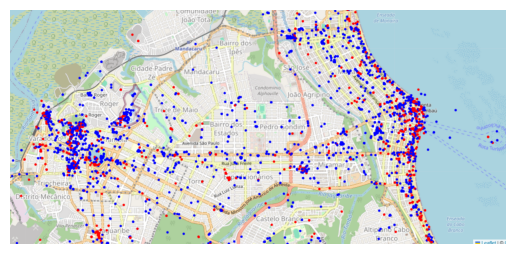

In [7]:
imagem = cv2.imread("mapa_densidade2.png")

# Converter a imagem para RGB (a biblioteca OpenCV lê a imagem no formato BGR)
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

# Exibir a imagem original
plt.imshow(imagem_rgb)
plt.axis('off')
plt.show()

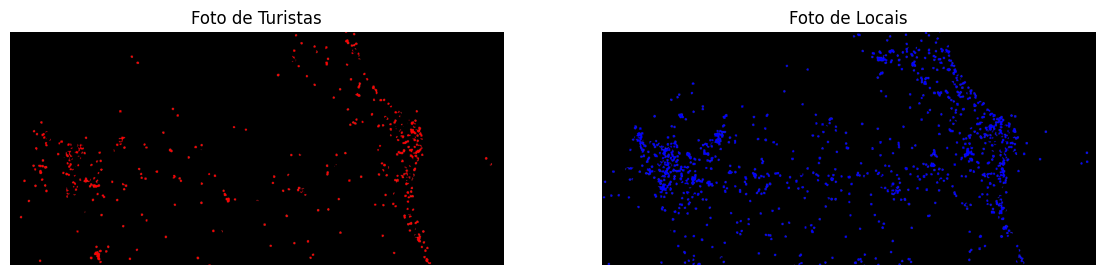

In [8]:
# Definir o intervalo de cores para vermelho e azul
vermelho_min = np.array([0, 0, 200], np.uint8)
vermelho_max = np.array([100, 100, 255], np.uint8)

azul_min = np.array([200, 0, 0], np.uint8)
azul_max = np.array([255, 100, 100], np.uint8)

# Segmentar os pontos vermelhos e azuis
mascara_vermelha = cv2.inRange(imagem, vermelho_min, vermelho_max)
mascara_azul = cv2.inRange(imagem, azul_min, azul_max)

# Aplicar a máscara sobre a imagem original para destacar os pontos vermelhos e azuis
pontos_vermelhos = cv2.bitwise_and(imagem_rgb, imagem_rgb, mask=mascara_vermelha)
pontos_azuis = cv2.bitwise_and(imagem_rgb, imagem_rgb, mask=mascara_azul)

# Exibir os pontos vermelhos e azuis
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

ax[0].imshow(pontos_vermelhos)
ax[0].set_title('Foto de Turistas')
ax[0].axis('off')

ax[1].imshow(pontos_azuis)
ax[1].set_title('Foto de Locais')
ax[1].axis('off')

plt.show()

In [10]:
# Função para identificar contornos nas máscaras
def identificar_contornos(mask):
    contornos, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contornos


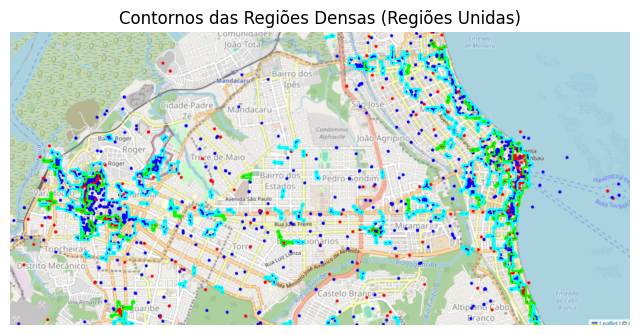

In [11]:
# Função para unir pontos próximos e formar regiões, ignorando pontos isolados
def unir_pontos(mask):
    # Aplicar uma operação de dilatação para unir os pontos próximos
    kernel = np.ones((15, 15), np.uint8)
    mascara_dilatada = cv2.dilate(mask, kernel, iterations=1)
    
    # Aplicar uma operação de erosão para remover pontos isolados
    mascara_erodida = cv2.erode(mascara_dilatada, kernel, iterations=1)
    
    # Remover contornos correspondentes a áreas muito pequenas (pontos isolados)
    contornos, _ = cv2.findContours(mascara_erodida, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contornos:
        area = cv2.contourArea(c)
        if area < 100:  # Definir um limite de área para remover pontos isolados
            cv2.drawContours(mascara_erodida, [c], -1, 0, -1)  # Preencher contornos pequenos com zeros
    
    return mascara_erodida

# Unir os pontos vermelhos e azuis para formar regiões
mascara_vermelha_unida = unir_pontos(mascara_vermelha)
mascara_azul_unida = unir_pontos(mascara_azul)

contornos_vermelhos_unidos = identificar_contornos(mascara_vermelha_unida)
contornos_azuis_unidos = identificar_contornos(mascara_azul_unida)

# Desenhar os contornos sobre a imagem original
imagem_contornos = imagem_rgb.copy()
cv2.drawContours(imagem_contornos, contornos_vermelhos_unidos, -1, (0, 255, 0), 4)
cv2.drawContours(imagem_contornos, contornos_azuis_unidos, -1, (0, 255, 255), 4)

# Exibir a imagem com os contornos identificados
plt.figure(figsize=(8, 6))
plt.imshow(imagem_contornos)
plt.title('Contornos das Regiões Densas (Regiões Unidas)')
plt.axis('off')
plt.show()
